In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r'data/train.csv')
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Basic data exploration

Here are a few inferences, you can draw by looking at the output of describe() function:

 * LoanAmount has (614 – 592) 22 missing values.
 * Loan_Amount_Term has (614 – 600) 14 missing values.
 * Credit_History has (614 – 564) 50 missing values.
 * We can also look that about 84% applicants have a credit_history. How? The mean of Credit_History field is 0.84 (Remember,  Credit_History has value 1 for those who have a credit history and 0 otherwise)
 * The ApplicantIncome distribution seems to be in line with expectation. Same with CoapplicantIncome
 
 Plus we can get an idea of a possible skew in the data by comparing the mean to the median (the 50% figure).

In [2]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [3]:
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [5]:
df['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [6]:
df['Education'].value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [7]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [8]:
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

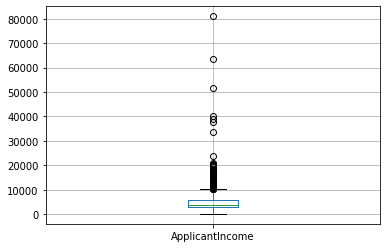

In [9]:
df.boxplot(column='ApplicantIncome')

We see some extreme/outliers values. This can be attributed to the income disparity in the society. Part of this can be driven by the fact that we are looking at people with different education levels. Let us segregate them by Education:

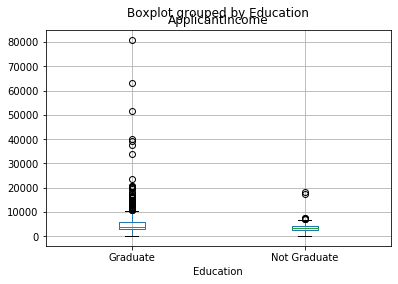

In [10]:
df.boxplot(column='ApplicantIncome', by = 'Education')

We can see that there is no substantial different between the mean income of graduate and non-graduates. But there are a higher number of graduates with very high incomes, which are appearing to be the outliers. Also we can see that graduates have bigger variability in their income.

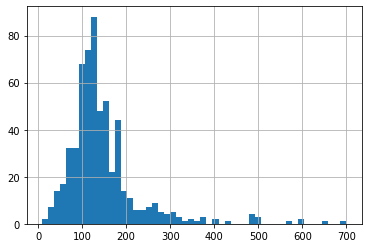

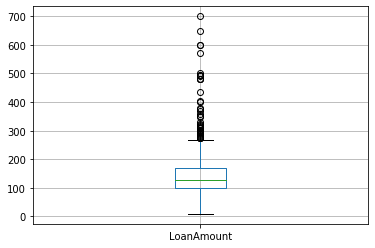

In [11]:
df['LoanAmount'].hist(bins=50)
plt.show()
plt.close()
df.boxplot(column='LoanAmount')
plt.show()

Again, there are some extreme values. Clearly, both ApplicantIncome and LoanAmount require some amount of data cleaning. LoanAmount has missing as well as extreme values values, while ApplicantIncome has a few extreme values, which demand deeper understanding.

### Categorical variables analysis

In [12]:
f_credit_hist = df['Credit_History'].value_counts()

df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
pivot_credit_hist = pd.pivot_table(df, values='Loan_Status', index=['Credit_History'], aggfunc=np.mean)

print('Frequency table:\n', f_credit_hist)
print('\n Pivot table:\n', pivot_credit_hist)

Frequency table:
 1.0    475
0.0     89
Name: Credit_History, dtype: int64

 Pivot table:
                 Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


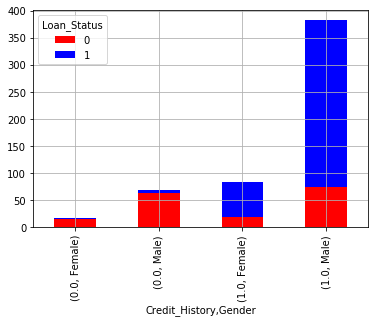

In [13]:
temp = pd.crosstab([df['Credit_History'], df['Gender']], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=True)

# Data Cleaning
Here are the problems, I am already aware of:

 1) There are missing values in some variables. We should estimate those values wisely depending on the amount of missing values and the expected importance of variables.
 
 2) While looking at the distributions, we saw that ApplicantIncome and LoanAmount seemed to contain extreme values at either end. Though they might make intuitive sense, but should be treated appropriately.

### Loan Amount
There are basicly three approaches:
 * fill NA with some mean/median/mode, mean should be good estimator
 * drop rows which contain NA values
 * build a simple model to predict loan amount from other features
As for first try I fill them with mean then evaluate impact of loan amount to final prediction

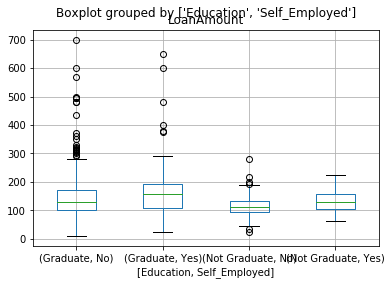

In [14]:
df.boxplot(column='LoanAmount', by = ['Education', 'Self_Employed'])

we see some variations in the median of loan amount for each group and this can be used to impute the values. But first, we have to ensure that each of Self_Employed and Education variables should not have a missing values.

In [15]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

We see that ~ 86% of values are no, its fairly save to fill NA with no

In [16]:
df['Self_Employed'].fillna('No', inplace=True)

In [17]:
medians = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
medians

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [18]:
def fill_median(x): 
    return medians.loc[x['Self_Employed'],x['Education']]

df['LoanAmount'][df['LoanAmount'].isnull()] = df[df['LoanAmount'].isnull()].apply(fill_median, axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

What about extremes? Since its possible to ask for such loan I will explore log transformation

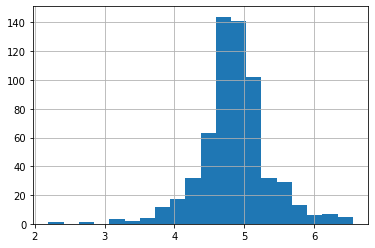

In [20]:
(np.log(df['LoanAmount'])).hist(bins=20)
df['LoanAmount_log'] = np.log(df['LoanAmount'])

seems good enough

Coming to ApplicantIncome. One intuition can be that some applicants have lower income but strong support Co-applicants. So it might be a good idea to combine both incomes as total income and take a log transformation of the same.

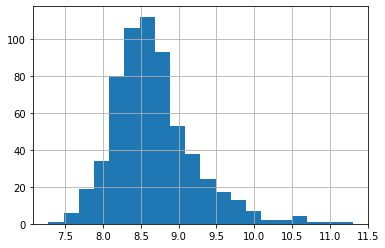

In [21]:
df['TotalIncome_log'] = np.log(df['ApplicantIncome'] + df['CoapplicantIncome'])
df['TotalIncome_log'].hist(bins=20)

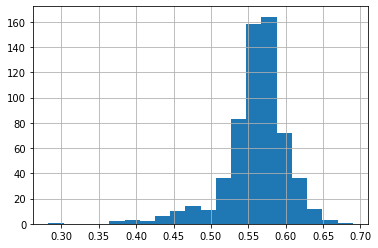

In [22]:
df['LoanAmount_TotalIncome'] = df['LoanAmount_log'] / df['TotalIncome_log']
df['LoanAmount_TotalIncome'].hist(bins=20)

LoanAmount/TotalIncome might make sense as it gives an idea of how well the applicant is suited to pay back his loan.

In [23]:
df['Gender'].fillna('Male', inplace=True)

again male ratio is 0.82

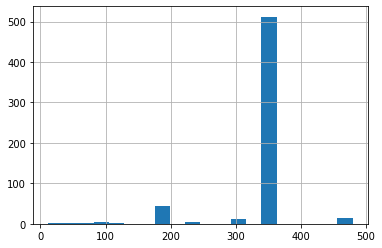

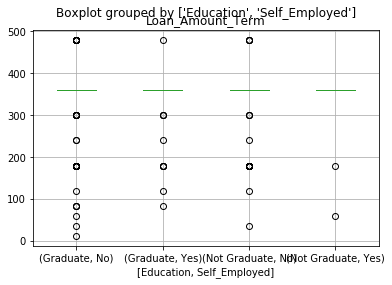

In [24]:
df['Loan_Amount_Term'].hist(bins=20)
plt.show()
plt.close()
df.boxplot(column='Loan_Amount_Term', by = ['Education', 'Self_Employed'])
plt.show()

I dont think wee see any major differencies, so filling with mean should be okey

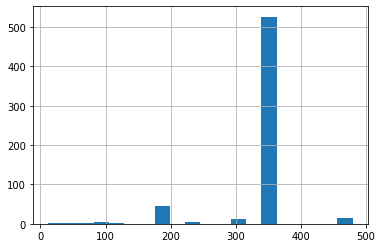

In [25]:
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace=True)
df['Loan_Amount_Term'].hist(bins=20)

In [26]:
print(df['Credit_History'].value_counts())
print(df['Credit_History'].mean())

1.0    475
0.0     89
Name: Credit_History, dtype: int64
0.8421985815602837


safe to fill with 1 (has cradit history), for sake of further data exploration I will fill it with 2 (we dont know)

In [27]:
df['Credit_History'].fillna(2, inplace=True)

In [28]:
df.isna().sum()

Loan_ID                    0
Gender                     0
Married                    3
Dependents                15
Education                  0
Self_Employed              0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Property_Area              0
Loan_Status                0
LoanAmount_log             0
TotalIncome_log            0
LoanAmount_TotalIncome     0
dtype: int64

In [29]:
print(df['Dependents'].value_counts())

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


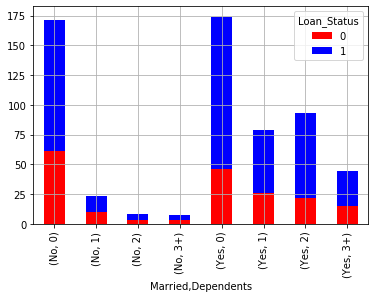

In [30]:
temp = pd.crosstab([df['Married'], df['Dependents']], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=True)

Makes sense to fill dependent with 0 because its major class in both cases

In [31]:
df['Dependents'].fillna('0', inplace=True)

In [32]:
df.isna().sum()

Loan_ID                   0
Gender                    0
Married                   3
Dependents                0
Education                 0
Self_Employed             0
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount                0
Loan_Amount_Term          0
Credit_History            0
Property_Area             0
Loan_Status               0
LoanAmount_log            0
TotalIncome_log           0
LoanAmount_TotalIncome    0
dtype: int64

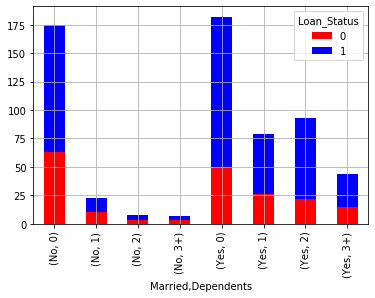

In [33]:
temp = pd.crosstab([df['Married'], df['Dependents']], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=True)

In [34]:
df.dropna(inplace=True)

In [35]:
df.isna().sum()

Loan_ID                   0
Gender                    0
Married                   0
Dependents                0
Education                 0
Self_Employed             0
ApplicantIncome           0
CoapplicantIncome         0
LoanAmount                0
Loan_Amount_Term          0
Credit_History            0
Property_Area             0
Loan_Status               0
LoanAmount_log            0
TotalIncome_log           0
LoanAmount_TotalIncome    0
dtype: int64

Now should be the training set ready for building a solid model!

In [39]:
df['TotalIncome'] = np.exp(df['TotalIncome_log'])
df.pivot_table(values='TotalIncome', index='Credit_History' ,columns='Loan_Status', aggfunc=np.mean)

Loan_Status,0,1
Credit_History,,
0.0,6877.560976,11252.000000
1.0,7400.371134,6843.487787
2.0,9568.461538,6555.027027


When we dont know credit history something mysterious is going on. People with higher income are rejected despite their income is almost on level "no credit history - approved" and vice versa.

In [40]:
df2 = df[df['Credit_History']==2]
df2.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,LoanAmount_log,TotalIncome_log,LoanAmount_TotalIncome,TotalIncome
count,50.000000,50.000000,50.000000,50.00000,50.0,50.000000,50.000000,50.000000,50.000000,50.000000
mean,4693.080000,2645.440000,160.460000,340.32000,2.0,0.740000,4.934661,8.695967,0.566962,7338.520000
std,3799.240605,5980.208095,106.608996,71.41641,0.0,0.443087,0.505657,0.574761,0.036226,6678.526708
min,416.000000,0.000000,58.000000,12.00000,2.0,0.000000,4.060443,7.539027,0.475071,1880.000000
25%,2675.000000,0.000000,99.250000,360.00000,2.0,0.250000,4.597632,8.346827,0.543056,4217.000000
50%,3644.000000,1583.500000,130.000000,360.00000,2.0,1.000000,4.867534,8.677887,0.567938,5873.000000
75%,5746.000000,2908.000000,184.250000,360.00000,2.0,1.000000,5.216269,8.902857,0.583567,7356.250000
max,20833.000000,41667.000000,650.000000,480.00000,2.0,1.000000,6.476972,10.647399,0.653464,42083.000000


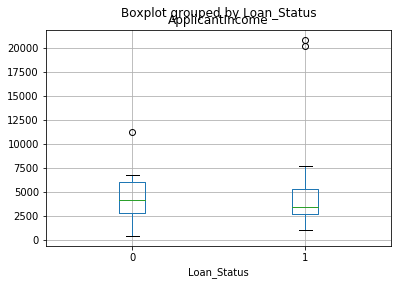

In [42]:
df2.boxplot(column='ApplicantIncome', by='Loan_Status')

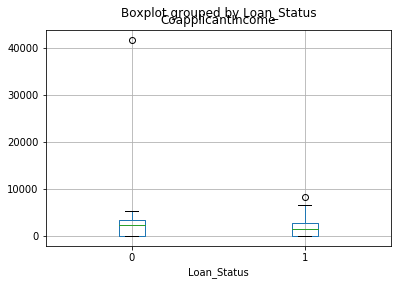

In [43]:
df2.boxplot(column='CoapplicantIncome', by='Loan_Status')

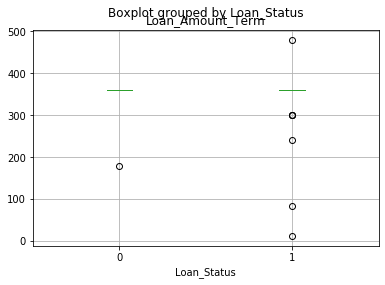

In [44]:
df2.boxplot(column='Loan_Amount_Term', by='Loan_Status')

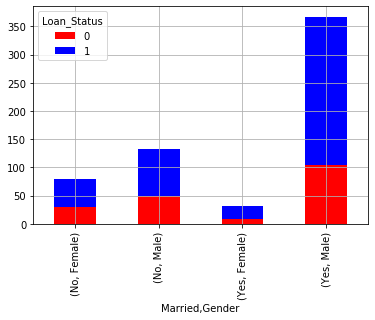

In [45]:
temp = pd.crosstab([df['Married'], df['Gender']], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=True)

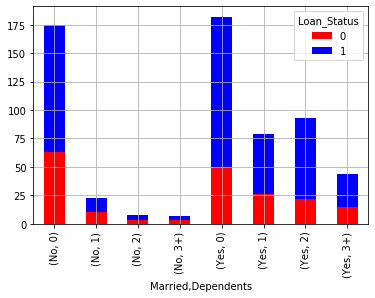

In [46]:
temp = pd.crosstab([df['Married'], df['Dependents']], df['Loan_Status'])
temp.plot(kind='bar', stacked=True, color=['red','blue'], grid=True)

In [47]:
import seaborn as sns

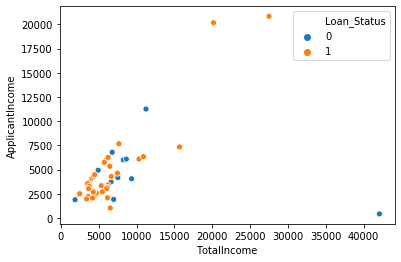

In [49]:
sns.scatterplot(data=df2, x='TotalIncome', y='ApplicantIncome', hue='Loan_Status')

There is no strong correlation between incomes and loan status when credit history is not known which is strange.

In [51]:
df2['Loan_Status'].value_counts()

1    37
0    13
Name: Loan_Status, dtype: int64

In [52]:
df2['Loan_Status'].mean()

0.74

In [58]:
from sklearn.feature_selection import SelectKBest, f_regression
from preprocess import Preprocess

df = pd.read_csv(r'data/train.csv')
p = Preprocess(df, 'train')
x, y = p.get_data_ml()

In [59]:
select = SelectKBest(f_regression, k=10)
select.fit(x, y)

SelectKBest(k=10, score_func=<function f_regression at 0x000001D869EC1510>)

In [67]:
res = pd.DataFrame()
res['feature'] = list(x.columns)
res['p'] = select.pvalues_
res['f'] = select.scores_
res['result'] = select.get_support()
res.sort_values('p')

,feature,p,f,result
20,Credit_History_0.0,7.019682e-48,252.652090,True
21,Credit_History_1.0,2.144507e-29,140.912799,True
24,Property_Area_Semiurban,6.929730e-04,11.626448,True
23,Property_Area_Rural,1.254748e-02,6.268796,True
11,Married_Yes,3.176574e-02,4.632305,True
10,Married_No,3.176574e-02,4.632305,True
16,Education_Graduate,3.336068e-02,4.547685,True
17,Education_Not Graduate,3.336068e-02,4.547685,True
1,CoapplicantIncome,9.433750e-02,2.807462,True
14,Dependents_2,1.225501e-01,2.391030,True


OK, from this handy sklearn procedure we can see which features are important.
 * Credit History - we see that if when its not known it isnt a factor as we suspect
 * Property area - there can be logic that different areas require much more or less loan, it requires further exploration
 * Mariage status - this is logical, married people represent more "stable" group
 * Education - no explanation needed
 * CoappliciantIncome - for me its suprising that is much more significant than Appliciant Income but it makes sense because when appliciant fails to pay for loan bank needs to be sure that there is someone who will pay.
 
OK, lets see some model performancies in model_selection.ipynb